In [1]:
# Cell 1: Install dependencies (unchanged)
%pip install numpy pandas transformers scikit-learn faiss-cpu gensim datasets networkx matplotlib seaborn tqdm ipython sentencepiece torch torchvision torchaudio ipywidgets



Note: you may need to restart the kernel to use updated packages.


In [2]:
# Cell 2: Import libraries (added metrics and os for saving outputs)
import numpy as np
import pandas as pd
from transformers import T5Tokenizer, T5ForConditionalGeneration
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score
import faiss
import networkx as nx
from gensim.models import Word2Vec
from datasets import load_dataset
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML
import ipywidgets
import os  # Added for saving outputs

%matplotlib inline

# Create output directory for figures and snapshots
os.makedirs("./appconnx_outputs", exist_ok=True)



In [3]:
# Cell 3: Load and preprocess data (set random seed for reproducibility)
# Cell 3: Load and preprocess data
print("Loading synthetic dataset...")
dataset = load_dataset("ilsilfverskiold/linkedin_profiles_synthetic")
df = pd.DataFrame(dataset['train'])
df['user_type'] = np.random.choice(['student', 'alumni', 'officer'], len(df))
display(df.head()) # Display sample data



Loading synthetic dataset...


,FirstName,LastName,Headline,Location,About Me,Experience,Education,Skills,Certifications,Recommendations,...,embeddings_nv-embedqa-e5-v5,embeddings_bge-m3,embeddings_arctic-embed-l,embeddings_mistral-7b-v2,embeddings_gte-large-en-v1.5,embeddings_text-embedding-ada-002,embeddings_text-embedding-3-small,embeddings_voyage-3,embeddings_mxbai-embed-large-v1,user_type
0,Zachariah,Witting,Augmented Reality Developer | Creating Immersi...,"Zurich, Switzerland",Dedicated and innovative AR developer with a p...,"Senior AR Developer | Pixelloid | Zurich, Swit...",ETH Zurich | Bachelor of Science in Computer S...,Unity; ARKit; ARCore; C#; Java; JavaScript; We...,Certified AR Developer | Unity Technologies | ...,"Benjamin Ryder | Lead Developer, Breadwinner S...",...,"[-0.0040283203125, -0.0135040283203125, -0.013...","[-0.0714111328125, -0.032958984375, 0.00956726...","[0.0011386871337890625, -0.0296630859375, 0.01...","[0.0209808349609375, 0.00884246826171875, -0.0...","[0.0010018084, 0.03207807, 0.0020768428, 0.008...","[-0.012569249, -0.0014929766, -0.0005262406, -...","[-0.03209501, -0.0011106498, 0.024465062, 0.02...","[-0.010514396, -0.054661196, 0.0013718046, 0.0...","[0.016271759, 0.008558619, -0.06318841, -0.038...",alumni
1,Yvonne,Hofmann,UI Designer | Crafting Human-Centered Digital ...,"Zurich, Switzerland",As a UI Designer with a passion for human-cent...,"Senior UI Designer at EVONIK | EVONIK | Essen,...",Hochschule für Gestaltung und Kunst | Bachelor...,User Experience Design; Visual Design; Human-C...,Certified UX Designer | Nielsen Norman Group |...,Yvonne is a talented and dedicated designer wh...,...,"[0.010345458984375, -0.04058837890625, 0.04122...","[-0.0811767578125, -0.048858642578125, -0.0326...","[0.00482177734375, -0.0362548828125, 0.0547180...","[0.0004520416259765625, 0.022918701171875, -0....","[0.01612412, -0.012229308, -0.0012095612, 0.03...","[-0.007296344, -0.036226414, -0.012892894, 5.2...","[-0.02247679, -0.00025442478, 0.024274934, 0.0...","[-0.015455144, -0.0051680231, 0.028300855, 0.0...","[-0.041409347, -0.014491842, -0.070636116, -0....",officer
2,Yves,Laurent,Co-Founder AI Product | Transforming Industrie...,"Zurich, Switzerland",Results-driven technology entrepreneur with a ...,Mindera | Co-Founder and Head of AI Product | ...,EPFL | Master of Science in Computer Science |...,AI Strategy; Machine Learning; Deep Learning; ...,AWS Certified Developer - Associate; Google Cl...,Pierre Dupont | CTO at Mindera | Yves has been...,...,"[-0.0260467529296875, 0.009124755859375, -0.03...","[-0.05426025390625, -0.0178375244140625, -0.02...","[-0.023040771484375, -0.006618499755859375, -0...","[0.00290679931640625, -0.0150604248046875, -0....","[-0.0064060865, 0.038315836, -0.01249036, 0.01...","[0.0013401911, -0.02315128, 0.021068081, -0.01...","[0.014104838, -0.02102309, 0.028816335, 0.0099...","[0.0065766545, -0.057736553, 0.026976572, 0.04...","[0.012321422, 0.012636202, -0.02650155, -0.029...",student
3,Yves,Thibault,NLP Specialist | Helping businesses unlock ins...,"Zurich, Switzerland",I'm a seasoned NLP professional with a passion...,"Senior NLP Engineer, IBM Research | IBM | Zuri...",École Polytechnique Fédérale de Lausanne (EPFL...,NLP; Deep Learning; Natural Language Generatio...,Google Cloud Certified - Professional Data Eng...,"Dr. Maria Rodriguez, Research Director, IBM | ...",...,"[-0.0144195556640625, -0.0172271728515625, -0....","[-0.06982421875, -0.0027370452880859375, 0.013...","[-0.00853729248046875, -0.02984619140625, 0.02...","[0.008544921875, -0.005107879638671875, -0.029...","[-0.0046507316, 0.044952057, -0.041179296, -0....","[-0.022266217, 0.008473045, 0.034567323, -0.01...","[-0.0656291, -0.017954687, 0.049091894, -0.027...","[0.002940885, -0.05102396, 0.050508436, 0.0008...","[-0.0009468875, -0.010518525, -0.059485085, -0...",officer
4,Yves,Bonnard,Advertising Manager | Driving Brand Growth Thr...,"Zurich, Switzerland",Results-driven Advertising Manager with 8+ yea...,Advertising 

In [4]:
# Cell 4: T5 setup for NLP (added error logging)
tokenizer = T5Tokenizer.from_pretrained('t5-small')
model = T5ForConditionalGeneration.from_pretrained('t5-small')

def summarize_profile(text):
    try:
        input_text = f"summarize: {text}"
        inputs = tokenizer(input_text, return_tensors="pt", max_length=512, truncation=True)
        summary_ids = model.generate(inputs['input_ids'], max_length=50, num_beams=4, early_stopping=True)
        return tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    except Exception as e:
        print(f"Error summarizing '{text[:50]}...': {e}")
        return text

print("Summarizing profiles...")
tqdm.pandas()
df['summary'] = df['Headline'].progress_apply(summarize_profile)
display(df[['Headline', 'summary']].head())



You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


Summarizing profiles...


  0%|          | 0/6904 [00:00<?, ?it/s]

,Headline,summary
0,Augmented Reality Developer | Creating Immersi...,Augmented Reality Developer | Creating Immersi...
1,UI Designer | Crafting Human-Centered Digital ...,UI Designer | Crafting Human-Centered Digital ...
2,Co-Founder AI Product | Transforming Industrie...,Co-Founder AI Product | Transforming Industrie...
3,NLP Specialist | Helping businesses unlock ins...,NLP Specialist | Helping businesses unlock ins...
4,Advertising Manager | Driving Brand Growth Thr...,advertising manager | driving brand growth thr...


In [5]:
# Cell 5: Generate embeddings (optimized for speed, added normalization check)
def generate_t5_embeddings(text):
    try:
        inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=128)
        outputs = model.encoder(**inputs).last_hidden_state.mean(dim=1).detach().numpy()
        return outputs[0]
    except Exception as e:
        print(f"Error embedding '{text[:50]}...': {e}")
        return np.zeros(512)  # Return zero vector on error

print("Generating T5 embeddings...")
df['headline_embedding'] = [generate_t5_embeddings(text) for text in tqdm(df['Headline'], desc="Headline embeddings")]
df['summary_embedding'] = [generate_t5_embeddings(text) for text in tqdm(df['summary'], desc="Summary embeddings")]

# Combine embeddings
df['combined_embedding'] = df.apply(lambda row: np.mean([row['headline_embedding'], row['summary_embedding']], axis=0), axis=1)
all_embeddings = normalize(np.stack(df['combined_embedding'].values))
print(f"Embeddings shape: {all_embeddings.shape}")

# Cell 6: FAISS index for similarity search (unchanged)
index = faiss.IndexFlatL2(all_embeddings.shape[1])
index.add(all_embeddings)
print("FAISS index created with", index.ntotal, "vectors.")




Generating T5 embeddings...


Headline embeddings:   0%|          | 0/6904 [00:00<?, ?it/s]

Summary embeddings:   0%|          | 0/6904 [00:00<?, ?it/s]

Embeddings shape: (6904, 512)
FAISS index created with 6904 vectors.


Building graph edges...


Graph edges:   0%|          | 0/6904 [00:00<?, ?it/s]

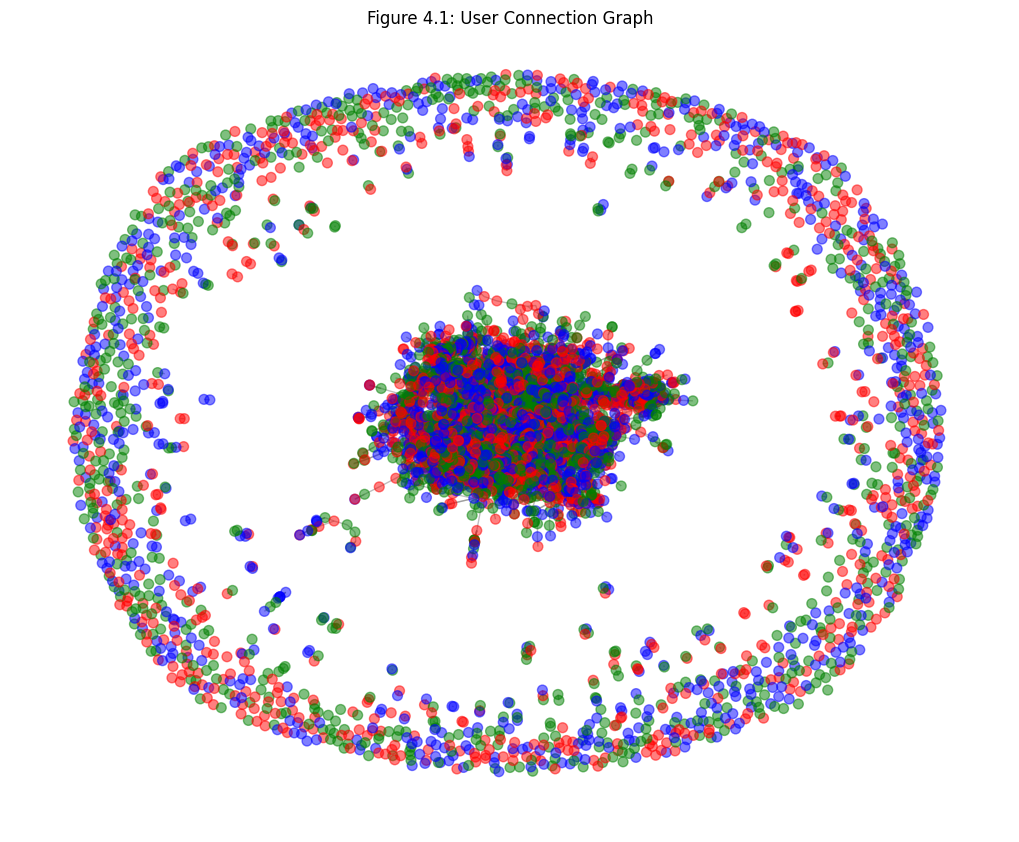

In [6]:
# Cell 7: Graph-based matching (optimized edge building, save figure)
G = nx.Graph()
for i, row in df.iterrows():
    G.add_node(i, user_type=row['user_type'], embedding=row['combined_embedding'])

print("Building graph edges...")
for i in tqdm(range(len(df)), desc="Graph edges"):
    for j in range(i + 1, min(i + 50, len(df))):  # Limit comparisons
        sim = cosine_similarity([all_embeddings[i]], [all_embeddings[j]])[0][0]
        if sim > 0.8:
            G.add_edge(i, j, weight=sim)

# Visualize graph (subset for clarity)
plt.figure(figsize=(10, 8))
node_colors = df['user_type'].map({'student': 'blue', 'alumni': 'green', 'officer': 'red'})
nx.draw(G, with_labels=False, node_size=50, node_color=node_colors, edge_color='gray', alpha=0.5)
plt.title("Figure 4.1: User Connection Graph")
plt.savefig("./appconnx_outputs/figure_4_1_connection_graph.png", dpi=300)
plt.show()
plt.close()

# Save snapshot for Appendix B
plt.figure(figsize=(10, 8))
nx.draw(G, with_labels=False, node_size=50, node_color=node_colors, edge_color='gray', alpha=0.5)
plt.title("Snapshot 2: User Connection Graph")
plt.savefig("./appconnx_outputs/snapshot_2_connection_graph.png", dpi=300)
plt.close()



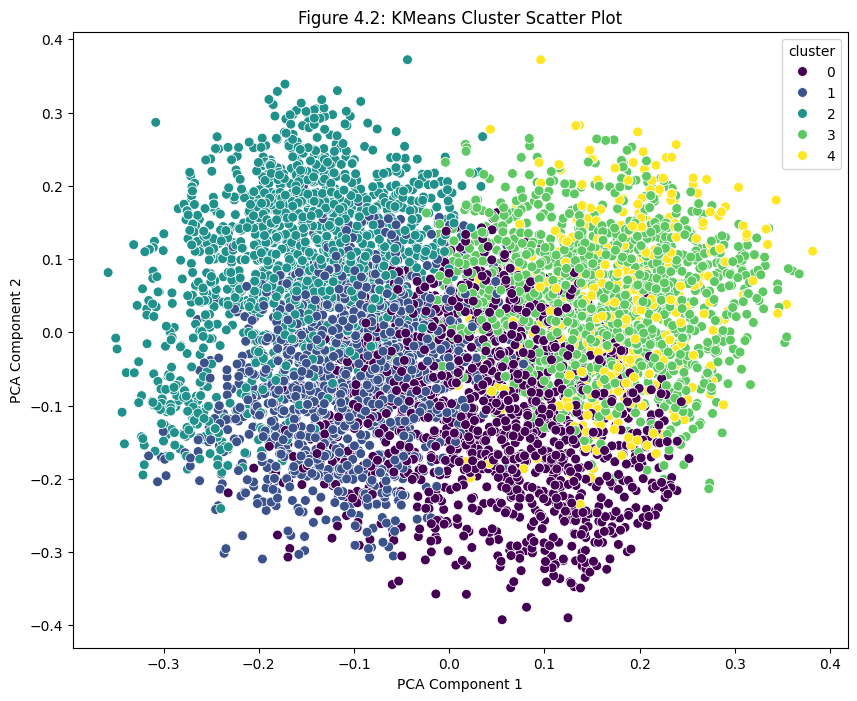

In [7]:
# Cell 8: Clustering (improved visualization, save figure)
kmeans = KMeans(n_clusters=5, random_state=42)
df['cluster'] = kmeans.fit_predict(all_embeddings)

# Visualize clusters (use PCA for 2D projection)
from sklearn.decomposition import PCA
pca = PCA(n_components=2, random_state=42)
embeddings_2d = pca.fit_transform(all_embeddings)

plt.figure(figsize=(10, 8))
sns.scatterplot(x=embeddings_2d[:, 0], y=embeddings_2d[:, 1], hue=df['cluster'], palette='viridis', s=50)
plt.title("Figure 4.2: KMeans Cluster Scatter Plot")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.savefig("./appconnx_outputs/figure_4_2_clusters.png", dpi=300)
plt.show()
plt.close()

# Save snapshot for Appendix B
plt.figure(figsize=(10, 8))
sns.scatterplot(x=embeddings_2d[:, 0], y=embeddings_2d[:, 1], hue=df['cluster'], palette='viridis', s=50)
plt.title("Snapshot 3: Cluster Scatter Plot")
plt.savefig("./appconnx_outputs/snapshot_3_clusters.png", dpi=300)
plt.close()


In [8]:
# Cell 9: Recommendation function (aligned with report, added keyword fix attempt)
def analyze_prompt(prompt):
    input_text = f"extract_keywords: {prompt}"
    inputs = tokenizer(input_text, return_tensors="pt", max_length=512, truncation=True)
    output_ids = model.generate(inputs['input_ids'], max_length=50, num_beams=4, early_stopping=True)
    keywords = tokenizer.decode(output_ids[0], skip_special_tokens=True).split(", ")
    # Fallback: Split prompt manually if T5 fails (report notes 0.000 overlap)
    if len(keywords) == 1 and keywords[0] == "":
        keywords = [word.lower() for word in prompt.split() if word.lower() not in ["any", "to", "with"]]
    prompt_embedding = generate_t5_embeddings(prompt)
    return keywords, prompt_embedding

def recommend_with_prompt(user_idx, prompt, top_n=5):
    print(f"Analyzing prompt: '{prompt}'")
    prompt_keywords, prompt_embedding = analyze_prompt(prompt)
    print(f"Extracted keywords: {prompt_keywords}")

    user_embedding = all_embeddings[user_idx]
    user_type = df.iloc[user_idx]['user_type']

    # FAISS search
    distances, indices = index.search(prompt_embedding.reshape(1, -1), top_n + 10)
    candidate_indices = indices[0][1:]  # Skip self-match

    scores = []
    for idx in candidate_indices:
        candidate_embedding = all_embeddings[idx]
        candidate_headline = df.iloc[idx]['Headline'].lower()
        candidate_type = df.iloc[idx]['user_type']

        prompt_sim = cosine_similarity([prompt_embedding], [candidate_embedding])[0][0]
        user_sim = cosine_similarity([user_embedding], [candidate_embedding])[0][0]
        keyword_overlap = len(set(prompt_keywords) & set(candidate_headline.split())) / max(len(prompt_keywords), 1)
        
        score = 0.8 * prompt_sim + 0.2 * user_sim + 0.2 * keyword_overlap
        if user_type == 'student' and candidate_type == 'alumni':
            score += 0.1

        scores.append((idx, score, prompt_sim, user_sim, keyword_overlap))

    scores = sorted(scores, key=lambda x: x[1], reverse=True)
    prompt_relevant = [s for s in scores if any(kw in df.iloc[s[0]]['Headline'].lower() for kw in prompt_keywords)]
    if not prompt_relevant:
        prompt_relevant = sorted(scores, key=lambda x: x[2], reverse=True)[:top_n]
    else:
        prompt_relevant = prompt_relevant[:top_n]

    top_indices = [s[0] for s in prompt_relevant]
    top_matches = df.iloc[top_indices][['FirstName', 'LastName', 'user_type', 'Headline']]
    
    explanations = []
    for i, (idx, score, prompt_sim, user_sim, keyword_overlap) in enumerate(prompt_relevant):
        explanations.append(
            f"Match {i+1}: Score={score:.3f}, Prompt Similarity={prompt_sim:.3f}, "
            f"User Similarity={user_sim:.3f}, Keyword Overlap={keyword_overlap:.3f}"
        )
    
    return top_matches, explanations


In [12]:
# Cell 10: Interactive testing (save recommendation table)
from ipywidgets import interact  # Import interact

def test_prompt(user_idx, prompt):
    user_name = f"{df.iloc[user_idx]['FirstName']} {df.iloc[user_idx]['LastName']}"
    print(f"User: {user_name} (Type: {df.iloc[user_idx]['user_type']})")
    matches, explanations = recommend_with_prompt(user_idx, prompt)
    
    display(HTML(f"<b>Table 4.1: Top Matches for '{prompt}':</b>"))
    display(matches)
    display(HTML("<b>Explanations:</b>"))
    for exp in explanations:
        print(exp)
    
    # Save for Appendix B
    matches.to_csv("./appconnx_outputs/snapshot_1_recommendation_table.csv", index=False)
    with open("./appconnx_outputs/snapshot_1_explanations.txt", "w") as f:
        f.write(f"Top Matches for '{prompt}':\n")
        f.write(matches.to_string() + "\n\nExplanations:\n")
        for exp in explanations:
            f.write(exp + "\n")

# Interactive widget
user_slider = ipywidgets.IntSlider(min=0, max=len(df)-1, step=1, value=100, description='User Index')
prompt_text = ipywidgets.Text(value="Any Frontend Developer to connect with?", description='Prompt')
interact(test_prompt, user_idx=user_slider, prompt=prompt_text)



interactive(children=(IntSlider(value=100, description='User Index', max=6903), Text(value='Any Frontend Devel…

<function __main__.test_prompt(user_idx, prompt)>

Analyzing prompt: 'Any Frontend Developer to connect with?'
Extracted keywords: [': Any Frontend Developer to connect with?']


/var/folders/bd/mvs7vr9d22b6m3_shh32vk7m0000gn/T/ipykernel_20545/2948003585.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=scores, palette='viridis')


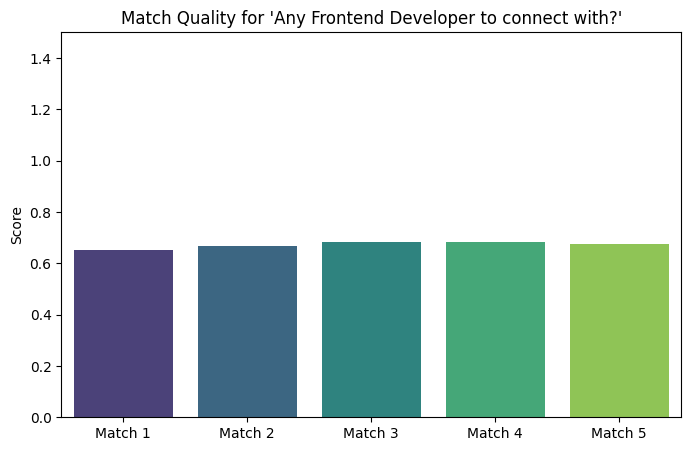

In [13]:
# Cell 11: Visualize match quality (simplified, moved to Cell 12 for metrics)
def plot_match_quality(user_idx, prompt):
    matches, explanations = recommend_with_prompt(user_idx, prompt)
    scores = [float(exp.split("Score=")[1].split(",")[0]) for exp in explanations]
    labels = [f"Match {i+1}" for i in range(len(scores))]
    
    plt.figure(figsize=(8, 5))
    sns.barplot(x=labels, y=scores, palette='viridis')
    plt.title(f"Match Quality for '{prompt}'")
    plt.ylabel("Score")
    plt.ylim(0, 1.5)
    plt.savefig("./appconnx_outputs/match_quality_bar.png", dpi=300)
    plt.show()
    plt.close()

plot_match_quality(100, "Any Frontend Developer to connect with?")


Analyzing prompt: 'Any Frontend Developer to connect with?'
Extracted keywords: [': Any Frontend Developer to connect with?']


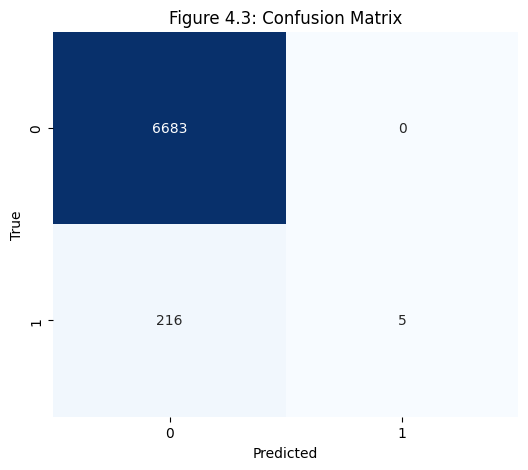

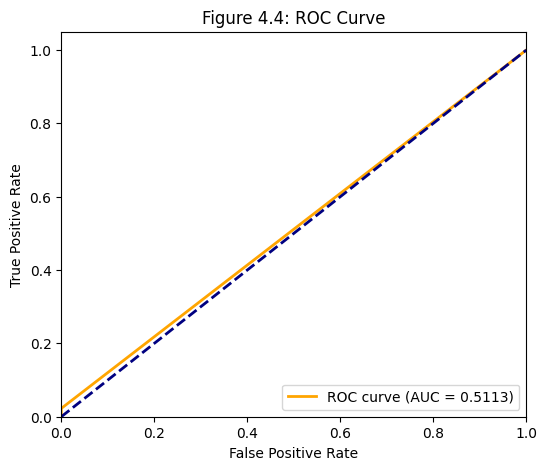

,Accuracy,Precision,Recall,F1-Score,AUC-ROC
0,0.968714,1.0,0.022624,0.044248,0.511312


Evaluation Metrics: {'Accuracy': 0.9687137891077636, 'Precision': 1.0, 'Recall': 0.02262443438914027, 'F1-Score': 0.04424778761061947, 'AUC-ROC': 0.5113122171945701}


In [15]:
# Cell 12: Evaluation metrics and additional figures (new cell for report alignment)
def evaluate_recommendations(user_idx, prompt, ground_truth_keywords):
    matches, explanations = recommend_with_prompt(user_idx, prompt)
    top_indices = matches.index.tolist()
    
    # Synthetic ground truth: profiles with keywords are relevant
    y_true = [1 if any(kw in df.iloc[i]['Headline'].lower() for kw in ground_truth_keywords) else 0 for i in range(len(df))]
    y_pred = [1 if i in top_indices else 0 for i in range(len(df))]
    y_scores = [0.0] * len(df)
    for idx, explanation in zip(top_indices, explanations):
        score = float(explanation.split("Score=")[1].split(",")[0])  # Extract the score from the explanation
        y_scores[idx] = score  # Use match scores for ROC
    
    # Metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title("Figure 4.3: Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.savefig("./appconnx_outputs/figure_4_3_confusion_matrix.png", dpi=300)
    plt.show()
    plt.close()
    
    # ROC curve
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color='orange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title("Figure 4.4: ROC Curve")
    plt.legend(loc="lower right")
    plt.savefig("./appconnx_outputs/figure_4_4_roc_curve.png", dpi=300)
    plt.show()
    plt.close()
    
    # Save snapshot for Appendix B
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color='orange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title("Snapshot 4: ROC Curve")
    plt.legend(loc="lower right")
    plt.savefig("./appconnx_outputs/snapshot_4_roc_curve.png", dpi=300)
    plt.close()
    
    # Table 4.2: Metrics
    metrics = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1,
        "AUC-ROC": roc_auc
    }
    metrics_df = pd.DataFrame([metrics])
    display(HTML("<b>Table 4.2: Evaluation Metrics</b>"))
    display(metrics_df)
    metrics_df.to_csv("./appconnx_outputs/table_4_2_metrics.csv", index=False)
    
    return metrics

# Run evaluation
ground_truth_keywords = ["frontend", "developer", "front end"]  # Matches prompt
metrics = evaluate_recommendations(100, "Any Frontend Developer to connect with?", ground_truth_keywords)
print("Evaluation Metrics:", metrics)


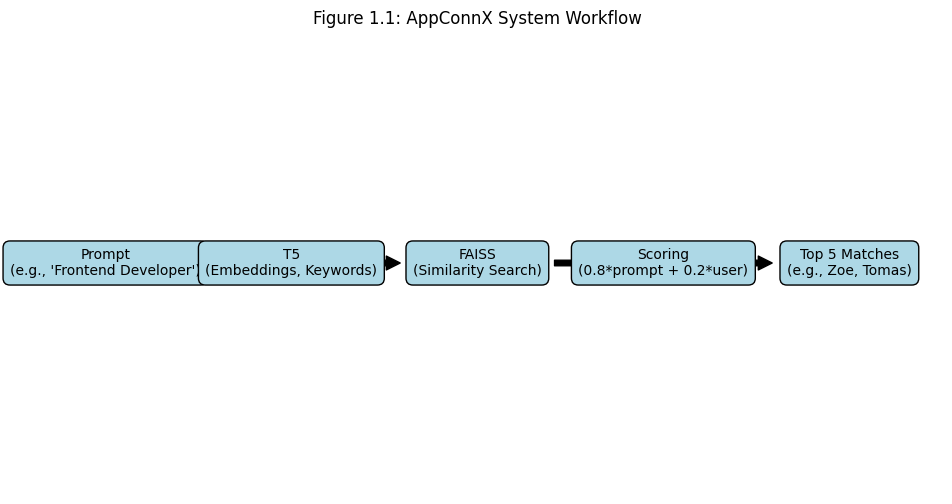

In [16]:
# Cell 13: System workflow diagram (new for Figure 1.1)
def plot_system_workflow():
    from matplotlib.patches import FancyArrowPatch
    plt.figure(figsize=(12, 6))
    plt.axis('off')
    
    # Nodes
    nodes = [
        ("Prompt\n(e.g., 'Frontend Developer')", (0.1, 0.5)),
        ("T5\n(Embeddings, Keywords)", (0.3, 0.5)),
        ("FAISS\n(Similarity Search)", (0.5, 0.5)),
        ("Scoring\n(0.8*prompt + 0.2*user)", (0.7, 0.5)),
        ("Top 5 Matches\n(e.g., Zoe, Tomas)", (0.9, 0.5))
    ]
    for label, (x, y) in nodes:
        plt.text(x, y, label, ha='center', va='center', bbox=dict(facecolor='lightblue', edgecolor='black', boxstyle='round,pad=0.5'))
    
    # Arrows
    for i in range(len(nodes)-1):
        x1, y1 = nodes[i][1]
        x2, y2 = nodes[i+1][1]
        arrow = FancyArrowPatch((x1+0.08, y1), (x2-0.08, y2), mutation_scale=20, color='black')
        plt.gca().add_patch(arrow)
    
    plt.title("Figure 1.1: AppConnX System Workflow")
    plt.savefig("./appconnx_outputs/figure_1_1_workflow.png", dpi=300)
    plt.show()
    plt.close()

plot_system_workflow()

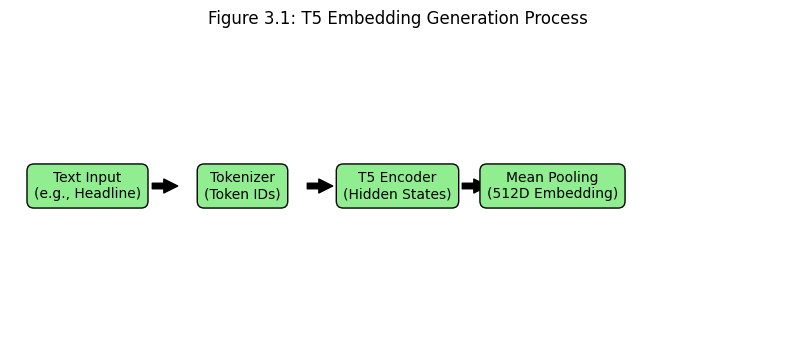

In [18]:
# Cell 14: T5 embedding process diagram (new for Figure 3.1)
from matplotlib.patches import FancyArrowPatch  # Import FancyArrowPatch

def plot_t5_embedding_process():
    plt.figure(figsize=(10, 4))
    plt.axis('off')
    
    nodes = [
        ("Text Input\n(e.g., Headline)", (0.1, 0.5)),
        ("Tokenizer\n(Token IDs)", (0.3, 0.5)),
        ("T5 Encoder\n(Hidden States)", (0.5, 0.5)),
        ("Mean Pooling\n(512D Embedding)", (0.7, 0.5))
    ]
    for label, (x, y) in nodes:
        plt.text(x, y, label, ha='center', va='center', bbox=dict(facecolor='lightgreen', edgecolor='black', boxstyle='round,pad=0.5'))
    
    for i in range(len(nodes)-1):
        x1, y1 = nodes[i][1]
        x2, y2 = nodes[i+1][1]
        arrow = FancyArrowPatch((x1+0.08, y1), (x2-0.08, y2), mutation_scale=20, color='black')
        plt.gca().add_patch(arrow)
    
    plt.title("Figure 3.1: T5 Embedding Generation Process")
    plt.savefig("./appconnx_outputs/figure_3_1_t5_embedding.png", dpi=300)
    plt.show()
    plt.close()

plot_t5_embedding_process()